In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
import keras.backend as K
%matplotlib inline

Using TensorFlow backend.


# MNIST DATASET

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

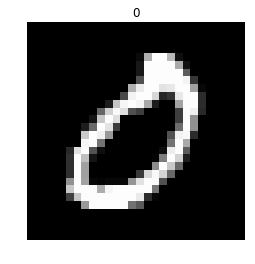

In [6]:
random_idx = np.random.choice(60000)
plt.imshow(x_train[random_idx], 'gray')
plt.title(y_train[random_idx])
plt.axis('off');

In [7]:
# Preprocesar las imagenes
x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

# Redimensionar las imagenes
x_train = x_train.reshape((-1,28*28))
x_test = x_test.reshape((-1,28*28))

x_train.shape, y_train.shape

((60000, 784), (60000,))

In [8]:
y_train[0]

5

Ojo: Esta vez no vamos a formatear nuestros labels a modo one-hot encode.

Si usamos la función de perdida "sparse_categorical_crossentropy", el modelo tratará los labels como si fueran one-hot encode.

# Construyendo el modelo en Keras

In [30]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(0.01), # <--- learning rate
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


# Definir manualmente un batch de entrenamiento

In [10]:
batch_size = 64

In [21]:
# 1. Obtener un minibatch
idxs = np.random.choice(len(x_train), batch_size, replace=False)
batch_x = x_train[idxs]
batch_y = y_train[idxs]
batch_x.shape, batch_y.shape

((64, 784), (64,))

In [24]:
# 2. Entrenar el batch
loss = model.train_on_batch(batch_x, batch_y)[0]
loss

2.4018195

# Actualizar el learning rate

In [25]:
# Obtener el learning rate del optimizador de nuestro modelo
K.eval(model.optimizer.lr)

0.0099999998

In [26]:
# Asignar nuevo valor de learning rate
K.eval(model.optimizer.lr.assign(0.002))

0.0020000001

# Encontrar un buen learning rate

1e-05 -> 1.0


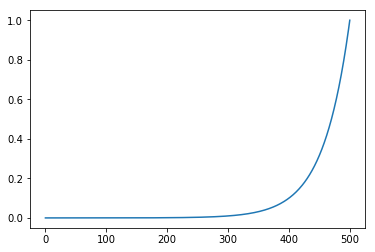

In [28]:
# 1. Definir una lista de learning rates a probar
iterations = 500
lr_list = 10 ** np.linspace(-5, 0, (iterations+1))
print(lr_list[0], '->', lr_list[-1])
plt.plot(lr_list);

In [29]:
# 2. Define una funcion que realize un batch de entrenamiento,
#    con un learning rate específico y retorne la perdida.

def get_loss(lr):
    K.eval(model.optimizer.lr.assign(lr))
    idxs = np.random.choice(len(x_train), batch_size, replace=False)
    batch_x = x_train[idxs]
    batch_y = y_train[idxs]
    loss = model.train_on_batch(batch_x, batch_y)[0]
    
    return loss

get_loss(0.001)

2.2633269

In [31]:
# 3. Obtengamos la perdida por cada learning rate en lr_list.
#    Antes de ejecutar este paso definan nuevamente el modelo,
#    para resetear los pesos.

losses = []

for i, lr in enumerate(lr_list):
    print('%d/%d...' % (i+1, len(lr_list)), end='\r')
    losses.append(get_loss(lr))
    if losses[-1] > np.min(losses)*6:
        # Si la perdida se hace muy grande, detenemos el loop
        break

print('\nDone :)')

395/501...
Done :)


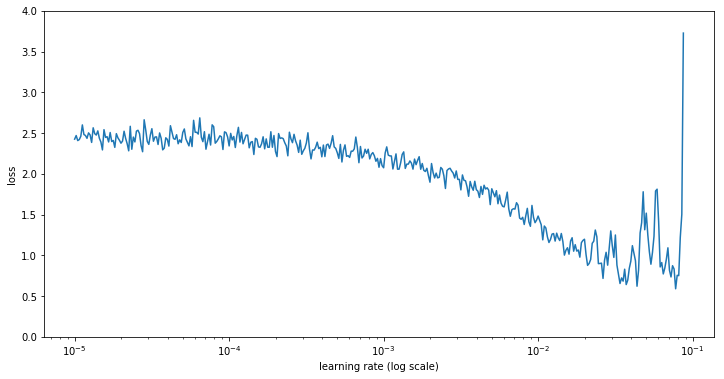

In [32]:
# 4. Observemos la perdida vs el learning rate
plt.figure(figsize=(12,6))
plt.plot(lr_list[:len(losses)], losses)
plt.ylabel('loss')
plt.xlabel('learning rate (log scale)')
plt.xscale('log')
plt.ylim(0,4);

# Definamos nuevamente el modelo y usemos el lr encontrado

In [34]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(0.02), # <--- learning rate
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [35]:
log = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=256)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s - loss: 0.8118 - acc: 0.7692 - val_loss: 0.4227 - val_acc: 0.8734
Epoch 2/5
60000/60000 [==============================] - 1s - loss: 0.3784 - acc: 0.8881 - val_loss: 0.3522 - val_acc: 0.8914
Epoch 3/5
60000/60000 [==============================] - 1s - loss: 0.3209 - acc: 0.9056 - val_loss: 0.3021 - val_acc: 0.9076
Epoch 4/5
60000/60000 [==============================] - 1s - loss: 0.2898 - acc: 0.9146 - val_loss: 0.2864 - val_acc: 0.9160
Epoch 5/5
60000/60000 [==============================] - 1s - loss: 0.2665 - acc: 0.9220 - val_loss: 0.2518 - val_acc: 0.9254


# Learning decay

El optimizador tiene un parametro decay:
* Asignenle un valor.
* Definan un loop de entrenamiento.
* Visualizen el cambio de learning rate.

In [44]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(0.02, decay=0.98), # <--- learning rate
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [45]:
K.eval(model.optimizer.lr)

0.02

In [46]:
log = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=256)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s - loss: 2.2101 - acc: 0.1932 - val_loss: 2.1712 - val_acc: 0.2178
Epoch 2/5
60000/60000 [==============================] - 1s - loss: 2.1617 - acc: 0.2280 - val_loss: 2.1484 - val_acc: 0.2359
Epoch 3/5
60000/60000 [==============================] - 1s - loss: 2.1450 - acc: 0.2407 - val_loss: 2.1353 - val_acc: 0.2475
Epoch 4/5
60000/60000 [==============================] - 1s - loss: 2.1343 - acc: 0.2492 - val_loss: 2.1261 - val_acc: 0.2546
Epoch 5/5
60000/60000 [==============================] - 1s - loss: 2.1263 - acc: 0.2550 - val_loss: 2.1189 - val_acc: 0.2601


In [47]:
K.eval(model.optimizer.lr)

0.02